In [2]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from pyDOE import lhs

## Glucaric Acid Synthesis Model

In [3]:
###Color palette
orders = ['Open Loop', 'Upstream Repression', 'Downstream Activation', 'Dual Control']
palette = {'Open Loop': sns.color_palette()[3], 'Upstream Repression': 'tab:orange', 'Downstream Activation': 'tab:green', 'Dual Control': 'tab:blue', 'Initial':'black'}

###Helper functions
def michaelismenten(x, vm, km):
    return (vm*x)/(km+x)

def reversible_michaelismenten(x, y, vm, keq, kmx, kmy):
    return (vm*(x - (y/keq)))/(x + kmx*(1+(y/kmy)))

def hilleqn(x, vm, n, km):
    return (vm*x**n)/(km**n + x**n)

def michaelismenten_substrateactivation(x, vm, km, a, ka):
    vm_eff = vm * (1+ (a*x)/(ka + x))
    return (vm_eff*x)/(km  + x)

def activation(x, k, theta, n):
    return (k*x**n)/(theta**n + x**n)
    
def repression(x, k, theta, n):
    return (k*theta**n)/(theta**n + x**n)
    
def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'Open Loop'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'

###Model definition
def glucaric_acid(t, y, ydot, params):

    lam = 2.7778E-05
    vm_pgi = 0.8751
    keq_pgi = 0.3
    km_pgi_g6p = 0.28
    km_pgi_f6p = 0.147
    vm_zwf = 0.0853
    km_zwf_g6p = 0.1
    vm_pfk = 2.615
    km_pfk_f6p = 0.16
    n_pfk = 3
    vm_ino1 = 0.2616
    km_ino1_g6p = 1.18
    km_t_mi = 15
    vm_miox = 0.2201
    km_miox_mi = 24.7
    a_miox = 5.4222
    ka_miox_mi = 20


    g6p, f6p, mi, ino1, miox, j1, j2 = y

    A, W, perturbs = params 
    v_pts = 0.1656*perturbs[0]
    vm_t_mi = 0.045*perturbs[0]

    n_ino1, theta_ino1, k_ino1 = W[0]
    n_miox, theta_miox, k_miox = W[1]

    v_pgi = reversible_michaelismenten(g6p, f6p, vm_pgi, keq_pgi, km_pgi_g6p, km_pgi_f6p)
    v_zwf = michaelismenten(g6p, vm_zwf, km_zwf_g6p)
    v_pfk = hilleqn(f6p, vm_pfk, n_pfk, km_pfk_f6p)
    v_ino1 = ino1 * michaelismenten(g6p, vm_ino1, km_ino1_g6p)
    v_tm = michaelismenten(mi, vm_t_mi, km_t_mi)
    v_miox = miox * michaelismenten_substrateactivation(mi, vm_miox, km_miox_mi, a_miox, ka_miox_mi)

    u_ino1_mi = np.sum(A[0]*np.array([activation(mi, k_ino1, theta_ino1, n_ino1), repression(mi, k_ino1, theta_ino1, n_ino1), k_ino1]))
    u_miox_mi = np.sum(A[1]*np.array([activation(mi, k_miox, theta_miox, n_miox), repression(mi, k_miox, theta_miox, n_miox), k_miox]))

    ydot[0] = v_pts - v_zwf - v_pgi - lam*g6p
    ydot[1] = v_pgi + 0.5*v_zwf - v_pfk - lam*f6p
    ydot[2] = v_ino1 - v_tm - v_miox - lam*mi
    ydot[3] = u_ino1_mi  - lam*ino1
    ydot[4] = u_miox_mi - lam*miox
    ydot[5] = (v_pts - v_miox)**2
    ydot[6] = u_ino1_mi + u_miox_mi

###Define search space
space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]]),
     ([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]]),
     ([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]]),
     ([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])

###Objective function
def run_hyperopt(max_iters):
    losses = []
    params = []
    circuits = []

    #Define objective function
    def objective(args):
        architecture, param_values = args
        #Integration conditions
        t = np.linspace(0, 5E5, 200) 
        y0 = np.array([0.281, 0.0605, 0., 0., 0. , 0., 0.]) #g6p, f6p, mi, ino1, miox

        extra_options = {'old_api': False, 'user_data': [architecture, param_values, perturbs], 'rtol':1E-4}
        ode_solver = ode('cvode', glucaric_acid, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-3)
        losses.append(loss)
        params.append(param_values)
        circuits.append(architecture)
        return loss
    

    #Run hyperopt call
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    #Create trajectory data frame
    landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'k1': [params[i][0][2] for i in range(len(params))], 'k2': [params[i][1][2] for i in range(len(params))], 'theta1': [params[i][0][1] for i in range(len(params))], 'theta2': [params[i][1][1] for i in range(len(params))]})  
    landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]
    landscape = landscape.reset_index()

    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss:
            best_loss = landscape.loss[i]
            best_circuit = landscape.Circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits

    return landscape, best

In [40]:
###Run sample optimization
max_iters = 1000
landscape, best = run_hyperopt(max_iters)
landscape.to_csv('sample_run.csv')

100%|██████████| 1000/1000 [00:41<00:00, 23.83trial/s, best loss: 0.11937918430748952]


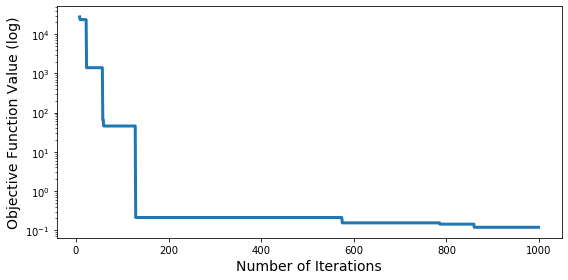

In [48]:
####FIGURE: Sample loss descent
fig, ax = plt.subplots(1,1,figsize=(8, 4))
prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape.best_loss_circuit[i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color=palette[a], linewidth=3)
ax.set_ylabel('Objective Function Value (log)', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)

fig.tight_layout()
fig.savefig('sample_loss_descent.png', dpi=300)


/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


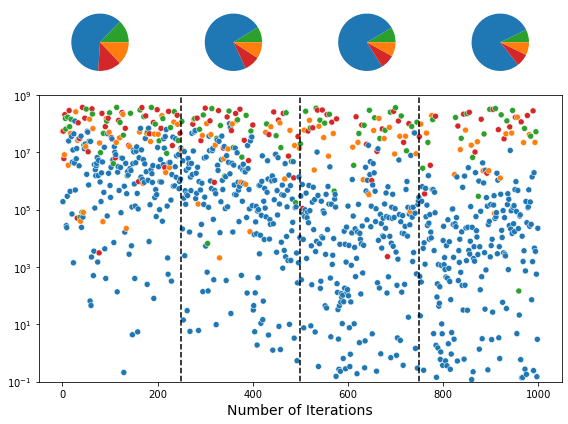

In [45]:
####FIGURE: Sample loss scatter and pie
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 4], width_ratios=[1, 1, 1, 1])

ax = fig.add_subplot(gs[1, :])
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_yscale('log')
ax.set_ylim([10E-2, 10E8])
sns.scatterplot(x='index', y='loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette, legend=False)
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(750, 0, 10E9, linestyles='dashed')
ax.set_ylabel(None)


quarter1 = (landscape.iloc[0:250].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter2 = (landscape.iloc[250:500].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter3 = (landscape.iloc[500:750].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
quarter4 = (landscape.iloc[750:1000].sort_values(by='Circuit').groupby('Circuit').count().loss/250).reset_index()
colors = ['tab:green', 'tab:blue', sns.color_palette()[3],  'tab:orange']

ax = fig.add_subplot(gs[0, 0])
ax.pie(quarter1.loss, colors=colors)

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter2.loss, colors=colors)

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter3.loss, colors=colors)

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter4.loss, colors=colors)

fig.tight_layout()
fig.savefig('sample_loss_scatter_pie.png', dpi=300)

In [46]:
###Explore kinetic robustness 

####FIGURE: Kinetic robustness

In [6]:
###Explore growth conditions robustness 
global perturbs
max_iters = 1000
total_landscape = pd.DataFrame()
total_perturbs = lhs(2, samples=500)
for p in total_perturbs:
    perturbs = p
    space = hp.choice('architecture', 
    [([[0, 1, 0], [0, 0, 1]], [[2., hp.uniform('theta1_ur', 1E-7, 10), hp.uniform('k1_ur', 1E-7, 5)], [2., hp.uniform('theta2_ur', 1E-7, 10), hp.uniform('k2_ur', 1E-7, 5)]])])
    ur_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [1, 0, 0]], [[2., hp.uniform('theta1_da', 1E-7, 10), hp.uniform('k1_da', 1E-7, 5)], [2., hp.uniform('theta2_da', 1E-7, 10), hp.uniform('k2_da', 1E-7, 5)]])])
    da_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 1, 0], [1, 0, 0]], [[2., hp.uniform('theta1_dc', 1E-7, 10), hp.uniform('k1_dc', 1E-7, 5)], [2., hp.uniform('theta2_dc', 1E-7, 10), hp.uniform('k2_dc', 1E-7, 5)]])])
    dc_landscape, best = run_hyperopt(max_iters)

    space = hp.choice('architecture', 
    [([[0, 0, 1], [0, 0, 1]], [[2., hp.uniform('theta1_nc', 1E-7, 10), hp.uniform('k1_nc', 1E-7, 5)], [2., hp.uniform('theta2_nc', 1E-7, 10), hp.uniform('k2_nc', 1E-7, 5)]])])
    nc_landscape, best = run_hyperopt(max_iters)

    landscape = pd.concat([ur_landscape, da_landscape, dc_landscape, nc_landscape])
    landscape['perturb0'] = p[0]
    landscape['perturb1'] = p[1]
    landscape.to_csv('growth_condition_robustness1.csv', mode='a', header=False)
    total_landscape = pd.concat([total_landscape, landscape])

total_landscape.to_csv('growth_conditions_robustness_backup1.csv')
####FIGURE: Robustness to growth conditions

 99%|█████████▉| 989/1000 [00:29<00:00, 30.55trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2476.9, mxstep steps taken before reaching tout.



 57%|█████▋    | 566/1000 [00:14<00:11, 36.26trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2445.14, mxstep steps taken before reaching tout.



 70%|███████   | 702/1000 [00:18<00:08, 33.12trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1403.33, mxstep steps taken before reaching tout.



  8%|▊         | 79/1000 [00:01<00:23, 39.04trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2081.33, mxstep steps taken before reaching tout.



 54%|█████▎    | 537/1000 [00:14<00:12, 35.72trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2478.78, mxstep steps taken before reaching tout.



 10%|▉         | 97/1000 [00:02<00:22, 41.01trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1128.47, mxstep steps taken before reaching tout.



 15%|█▌        | 151/1000 [00:03<00:21, 38.93trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1144.34, mxstep steps taken before reaching tout.



 17%|█▋        | 174/1000 [00:04<00:20, 39.94trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1978.37, mxstep steps taken before reaching tout.



 50%|████▉     | 496/1000 [00:12<00:13, 36.15trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1784.37, mxstep steps taken before reaching tout.



 57%|█████▊    | 575/1000 [00:14<00:11, 35.73trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 874.99, mxstep steps taken before reaching tout.



 53%|█████▎    | 530/1000 [00:13<00:12, 37.22trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 1971.97, mxstep steps taken before reaching tout.



 64%|██████▍   | 643/1000 [00:16<00:09, 35.76trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1645.65, mxstep steps taken before reaching tout.



 94%|█████████▎| 937/1000 [00:25<00:01, 32.13trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1136.78, mxstep steps taken before reaching tout.



 35%|███▍      | 349/1000 [00:08<00:18, 35.97trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1500.04, mxstep steps taken before reaching tout.



 36%|███▌      | 355/1000 [00:09<00:21, 30.04trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1030.72, mxstep steps taken before reaching tout.



 11%|█         | 111/1000 [00:02<00:22, 40.04trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1567.46, mxstep steps taken before reaching tout.



 97%|█████████▋| 966/1000 [00:25<00:01, 33.02trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1862.66, mxstep steps taken before reaching tout.



  2%|▏         | 22/1000 [00:00<00:20, 48.32trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1583.2, mxstep steps taken before reaching tout.



 66%|██████▌   | 660/1000 [00:17<00:10, 33.95trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2223.99, mxstep steps taken before reaching tout.



 44%|████▍     | 438/1000 [00:10<00:14, 38.74trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2288.03, mxstep steps taken before reaching tout.



 86%|████████▌ | 855/1000 [00:22<00:04, 33.83trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 839.857, mxstep steps taken before reaching tout.



  7%|▋         | 66/1000 [00:01<00:22, 40.91trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2231.9, mxstep steps taken before reaching tout.



 72%|███████▏  | 716/1000 [00:18<00:08, 33.34trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2251.75, mxstep steps taken before reaching tout.



 19%|█▊        | 187/1000 [00:04<00:20, 40.57trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 879.403, mxstep steps taken before reaching tout.



 72%|███████▏  | 723/1000 [00:19<00:08, 33.52trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2404.92, mxstep steps taken before reaching tout.



 27%|██▋       | 267/1000 [00:06<00:19, 38.23trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1434.36, mxstep steps taken before reaching tout.



 98%|█████████▊| 982/1000 [00:25<00:00, 33.89trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2127.81, mxstep steps taken before reaching tout.



 71%|███████   | 708/1000 [00:17<00:07, 36.71trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1823.19, mxstep steps taken before reaching tout.



 10%|▉         | 95/1000 [00:02<00:22, 39.62trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1879.04, mxstep steps taken before reaching tout.



  0%|          | 5/1000 [00:00<00:20, 47.77trial/s, best loss: 20416955.961140893]


[CVODE ERROR]  CVode
  At t = 1929.84, mxstep steps taken before reaching tout.



 50%|█████     | 503/1000 [00:12<00:13, 36.28trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2413.13, mxstep steps taken before reaching tout.



  3%|▎         | 28/1000 [00:00<00:21, 45.01trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1316.2, mxstep steps taken before reaching tout.



 15%|█▌        | 154/1000 [00:03<00:20, 41.10trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 2318.62, mxstep steps taken before reaching tout.



  8%|▊         | 80/1000 [00:01<00:22, 41.72trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2139.2, mxstep steps taken before reaching tout.



 74%|███████▎  | 735/1000 [00:19<00:08, 32.73trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1222.56, mxstep steps taken before reaching tout.



 96%|█████████▋| 964/1000 [00:24<00:01, 32.74trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1159.91, mxstep steps taken before reaching tout.



  2%|▏         | 18/1000 [00:00<00:19, 49.86trial/s, best loss: 0.0]             


[CVODE ERROR]  CVode
  At t = 984.956, mxstep steps taken before reaching tout.



  4%|▎         | 36/1000 [00:00<00:22, 43.04trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 710.497, mxstep steps taken before reaching tout.



 12%|█▏        | 117/1000 [00:02<00:21, 40.28trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1421.84, mxstep steps taken before reaching tout.



 11%|█▏        | 113/1000 [00:02<00:21, 40.64trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1671.94, mxstep steps taken before reaching tout.



 77%|███████▋  | 766/1000 [00:19<00:06, 34.53trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2177.46, mxstep steps taken before reaching tout.



 30%|███       | 304/1000 [00:07<00:17, 39.38trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1866.3, mxstep steps taken before reaching tout.



 28%|██▊       | 285/1000 [00:07<00:18, 39.39trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1135.53, mxstep steps taken before reaching tout.



  2%|▏         | 18/1000 [00:00<00:19, 49.38trial/s, best loss: 0.0]             


[CVODE ERROR]  CVode
  At t = 1113.08, mxstep steps taken before reaching tout.



 66%|██████▋   | 664/1000 [00:17<00:09, 34.46trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1864.23, mxstep steps taken before reaching tout.



 24%|██▍       | 243/1000 [00:05<00:18, 39.95trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1391.64, mxstep steps taken before reaching tout.



 33%|███▎      | 327/1000 [00:08<00:17, 37.91trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1513.22, mxstep steps taken before reaching tout.



 32%|███▏      | 319/1000 [00:07<00:17, 38.89trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 995.914, mxstep steps taken before reaching tout.



 41%|████▏     | 414/1000 [00:10<00:15, 38.04trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2361.06, mxstep steps taken before reaching tout.



  8%|▊         | 85/1000 [00:01<00:22, 41.54trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1111.02, mxstep steps taken before reaching tout.



 34%|███▍      | 343/1000 [00:08<00:17, 37.79trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1992.68, mxstep steps taken before reaching tout.



  7%|▋         | 70/1000 [00:01<00:23, 40.10trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 786.627, mxstep steps taken before reaching tout.



 13%|█▎        | 128/1000 [00:03<00:22, 38.73trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1626.73, mxstep steps taken before reaching tout.



 36%|███▋      | 365/1000 [00:09<00:17, 36.81trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 860.969, mxstep steps taken before reaching tout.



 74%|███████▍  | 740/1000 [00:18<00:07, 35.59trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1312.24, mxstep steps taken before reaching tout.



  2%|▏         | 23/1000 [00:00<00:20, 48.79trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1486.4, mxstep steps taken before reaching tout.



 62%|██████▎   | 625/1000 [00:16<00:10, 34.33trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1617.96, mxstep steps taken before reaching tout.



 56%|█████▌    | 557/1000 [00:14<00:12, 35.38trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1689.17, mxstep steps taken before reaching tout.



 55%|█████▌    | 554/1000 [00:14<00:12, 35.26trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 929.337, mxstep steps taken before reaching tout.



 24%|██▍       | 243/1000 [00:06<00:19, 38.46trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1633.73, mxstep steps taken before reaching tout.



 48%|████▊     | 478/1000 [00:11<00:14, 35.80trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2341.67, mxstep steps taken before reaching tout.



 25%|██▌       | 251/1000 [00:06<00:19, 37.90trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 854.55, mxstep steps taken before reaching tout.



 96%|█████████▌| 957/1000 [00:26<00:01, 31.50trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2340.84, mxstep steps taken before reaching tout.



 15%|█▍        | 146/1000 [00:03<00:21, 39.55trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2107.6, mxstep steps taken before reaching tout.



 34%|███▍      | 344/1000 [00:08<00:17, 36.88trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1665.9, mxstep steps taken before reaching tout.



 68%|██████▊   | 682/1000 [00:16<00:08, 37.52trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1929.43, mxstep steps taken before reaching tout.



 42%|████▏     | 420/1000 [00:10<00:15, 37.59trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1367.84, mxstep steps taken before reaching tout.



 14%|█▍        | 138/1000 [00:03<00:21, 40.06trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1508.34, mxstep steps taken before reaching tout.



  9%|▉         | 93/1000 [00:02<00:22, 40.98trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2231.31, mxstep steps taken before reaching tout.



 94%|█████████▍| 944/1000 [00:25<00:01, 31.18trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1209.81, mxstep steps taken before reaching tout.



 14%|█▎        | 137/1000 [00:03<00:21, 39.29trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1669.47, mxstep steps taken before reaching tout.



 43%|████▎     | 426/1000 [00:10<00:14, 38.40trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1035.99, mxstep steps taken before reaching tout.



  6%|▌         | 55/1000 [00:01<00:23, 39.94trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2272.91, mxstep steps taken before reaching tout.



 44%|████▍     | 440/1000 [00:11<00:15, 35.42trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1531.39, mxstep steps taken before reaching tout.



 98%|█████████▊| 980/1000 [00:26<00:00, 31.09trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2436.6, mxstep steps taken before reaching tout.



 33%|███▎      | 333/1000 [00:08<00:16, 40.05trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1137.23, mxstep steps taken before reaching tout.



 73%|███████▎  | 727/1000 [00:19<00:09, 29.18trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2248.46, mxstep steps taken before reaching tout.



 50%|████▉     | 498/1000 [00:12<00:14, 35.38trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2276.04, mxstep steps taken before reaching tout.



 19%|█▉        | 193/1000 [00:04<00:20, 39.72trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2342.97, mxstep steps taken before reaching tout.



 27%|██▋       | 267/1000 [00:06<00:18, 40.34trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2194.41, mxstep steps taken before reaching tout.



 37%|███▋      | 369/1000 [00:09<00:16, 37.73trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2338.36, mxstep steps taken before reaching tout.



 88%|████████▊ | 879/1000 [00:23<00:03, 31.56trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1728, mxstep steps taken before reaching tout.



 80%|████████  | 802/1000 [00:20<00:05, 35.64trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1675.36, mxstep steps taken before reaching tout.



 18%|█▊        | 179/1000 [00:04<00:20, 39.75trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 691.913, mxstep steps taken before reaching tout.



  6%|▌         | 60/1000 [00:01<00:24, 39.10trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1516.95, mxstep steps taken before reaching tout.



 78%|███████▊  | 777/1000 [00:20<00:06, 33.25trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 665.885, mxstep steps taken before reaching tout.



 74%|███████▎  | 737/1000 [00:19<00:07, 34.17trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2511.91, mxstep steps taken before reaching tout.



 75%|███████▍  | 748/1000 [00:19<00:07, 33.00trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1768.42, mxstep steps taken before reaching tout.



 25%|██▌       | 252/1000 [00:06<00:19, 37.55trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2037.4, mxstep steps taken before reaching tout.



 90%|████████▉ | 899/1000 [00:23<00:02, 35.43trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 1827.77, mxstep steps taken before reaching tout.



 86%|████████▌ | 860/1000 [00:23<00:04, 31.44trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2091.32, mxstep steps taken before reaching tout.



 62%|██████▏   | 621/1000 [00:16<00:10, 36.06trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2253.88, mxstep steps taken before reaching tout.



 68%|██████▊   | 680/1000 [00:17<00:09, 35.34trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2310.32, mxstep steps taken before reaching tout.



 34%|███▍      | 338/1000 [00:08<00:17, 38.27trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 843.895, mxstep steps taken before reaching tout.



  2%|▏         | 18/1000 [00:00<00:19, 49.60trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1188.76, mxstep steps taken before reaching tout.



  1%|          | 10/1000 [00:00<00:21, 46.91trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1648.35, mxstep steps taken before reaching tout.



  1%|          | 12/1000 [00:00<00:20, 48.03trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 903.374, mxstep steps taken before reaching tout.



 74%|███████▍  | 742/1000 [00:19<00:07, 34.84trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2006.95, mxstep steps taken before reaching tout.



  5%|▌         | 52/1000 [00:01<00:23, 39.63trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1644.38, mxstep steps taken before reaching tout.



 43%|████▎     | 429/1000 [00:10<00:14, 40.54trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2451.7, mxstep steps taken before reaching tout.



 42%|████▏     | 419/1000 [00:10<00:15, 38.54trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2151.5, mxstep steps taken before reaching tout.



 20%|█▉        | 195/1000 [00:04<00:21, 37.52trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 994.833, mxstep steps taken before reaching tout.



 22%|██▎       | 225/1000 [00:05<00:20, 38.26trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1781.32, mxstep steps taken before reaching tout.



 96%|█████████▌| 960/1000 [00:26<00:01, 31.47trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1430.79, mxstep steps taken before reaching tout.



 87%|████████▋ | 868/1000 [00:22<00:03, 33.81trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1764.46, mxstep steps taken before reaching tout.



 73%|███████▎  | 734/1000 [00:18<00:07, 35.50trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 2422.72, mxstep steps taken before reaching tout.



 83%|████████▎ | 829/1000 [00:22<00:04, 35.21trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1021.42, mxstep steps taken before reaching tout.



 17%|█▋        | 172/1000 [00:04<00:20, 40.85trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1247.34, mxstep steps taken before reaching tout.



 83%|████████▎ | 827/1000 [00:22<00:05, 33.53trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2225.63, mxstep steps taken before reaching tout.



 10%|▉         | 95/1000 [00:02<00:22, 40.79trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 702.619, mxstep steps taken before reaching tout.



 66%|██████▋   | 663/1000 [00:17<00:10, 33.29trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2069.56, mxstep steps taken before reaching tout.



 38%|███▊      | 385/1000 [00:09<00:17, 36.15trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 699.708, mxstep steps taken before reaching tout.



 16%|█▌        | 160/1000 [00:04<00:22, 37.10trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 2434.28, mxstep steps taken before reaching tout.



 69%|██████▉   | 688/1000 [00:18<00:08, 34.76trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1117.35, mxstep steps taken before reaching tout.



 72%|███████▏  | 723/1000 [00:18<00:07, 35.08trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2509.82, mxstep steps taken before reaching tout.



 98%|█████████▊| 977/1000 [00:25<00:00, 32.25trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1307.62, mxstep steps taken before reaching tout.



 88%|████████▊ | 881/1000 [00:23<00:03, 30.24trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1359.78, mxstep steps taken before reaching tout.



 18%|█▊        | 175/1000 [00:04<00:20, 40.53trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 773.026, mxstep steps taken before reaching tout.



 34%|███▍      | 341/1000 [00:08<00:17, 37.82trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1481.9, mxstep steps taken before reaching tout.



 34%|███▎      | 335/1000 [00:08<00:17, 37.31trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1019.54, mxstep steps taken before reaching tout.



 32%|███▏      | 315/1000 [00:07<00:16, 41.71trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1864.71, mxstep steps taken before reaching tout.



  8%|▊         | 79/1000 [00:01<00:23, 39.15trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1972.34, mxstep steps taken before reaching tout.



 47%|████▋     | 473/1000 [00:12<00:14, 37.47trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1960.42, mxstep steps taken before reaching tout.



 67%|██████▋   | 671/1000 [00:17<00:09, 34.96trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1308.6, mxstep steps taken before reaching tout.



 96%|█████████▌| 959/1000 [00:25<00:01, 32.25trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2363.41, mxstep steps taken before reaching tout.



 58%|█████▊    | 576/1000 [00:14<00:12, 34.80trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1554.12, mxstep steps taken before reaching tout.



 66%|██████▌   | 661/1000 [00:17<00:10, 33.63trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2291.87, mxstep steps taken before reaching tout.



 37%|███▋      | 367/1000 [00:09<00:17, 36.76trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1922.72, mxstep steps taken before reaching tout.



 21%|██        | 208/1000 [00:04<00:19, 41.58trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1667.95, mxstep steps taken before reaching tout.



 24%|██▍       | 244/1000 [00:05<00:19, 38.44trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1549.27, mxstep steps taken before reaching tout.



 43%|████▎     | 433/1000 [00:11<00:16, 33.69trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1658.59, mxstep steps taken before reaching tout.



 42%|████▏     | 418/1000 [00:10<00:14, 40.99trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1588.99, mxstep steps taken before reaching tout.



 69%|██████▉   | 688/1000 [00:18<00:09, 34.53trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2439.26, mxstep steps taken before reaching tout.



 98%|█████████▊| 976/1000 [00:25<00:00, 32.15trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1767.91, mxstep steps taken before reaching tout.



 97%|█████████▋| 966/1000 [00:25<00:01, 32.94trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1617.51, mxstep steps taken before reaching tout.



  7%|▋         | 70/1000 [00:01<00:23, 39.03trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2193.68, mxstep steps taken before reaching tout.



 38%|███▊      | 384/1000 [00:10<00:18, 33.34trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1568.01, mxstep steps taken before reaching tout.



 95%|█████████▌| 953/1000 [00:26<00:01, 31.01trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2227.59, mxstep steps taken before reaching tout.



 15%|█▌        | 154/1000 [00:03<00:21, 39.21trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 2069.77, mxstep steps taken before reaching tout.



  4%|▍         | 43/1000 [00:00<00:22, 42.53trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 917.357, mxstep steps taken before reaching tout.



 58%|█████▊    | 578/1000 [00:14<00:11, 36.23trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 710.013, mxstep steps taken before reaching tout.



 66%|██████▌   | 657/1000 [00:17<00:09, 35.84trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1137.87, mxstep steps taken before reaching tout.



 24%|██▍       | 244/1000 [00:05<00:19, 38.74trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2502.83, mxstep steps taken before reaching tout.



  6%|▌         | 56/1000 [00:01<00:23, 40.48trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 1715.6, mxstep steps taken before reaching tout.



 13%|█▎        | 127/1000 [00:03<00:20, 41.61trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1525.59, mxstep steps taken before reaching tout.



 96%|█████████▋| 964/1000 [00:27<00:01, 31.03trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2205.17, mxstep steps taken before reaching tout.



 32%|███▏      | 317/1000 [00:07<00:17, 40.00trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1049.65, mxstep steps taken before reaching tout.



 68%|██████▊   | 685/1000 [00:17<00:08, 36.12trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 646.081, mxstep steps taken before reaching tout.



 91%|█████████ | 906/1000 [00:23<00:02, 33.50trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2378.93, mxstep steps taken before reaching tout.



 12%|█▏        | 122/1000 [00:02<00:21, 40.27trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1405.51, mxstep steps taken before reaching tout.



 28%|██▊       | 284/1000 [00:06<00:17, 39.85trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1887.14, mxstep steps taken before reaching tout.



 94%|█████████▎| 936/1000 [00:25<00:01, 32.30trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 648.539, mxstep steps taken before reaching tout.



 33%|███▎      | 326/1000 [00:08<00:18, 35.50trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2311.17, mxstep steps taken before reaching tout.



 10%|▉         | 99/1000 [00:02<00:21, 41.18trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 861.965, mxstep steps taken before reaching tout.



 14%|█▍        | 138/1000 [00:03<00:21, 40.72trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2189.81, mxstep steps taken before reaching tout.



 75%|███████▍  | 747/1000 [00:20<00:07, 33.33trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2398.69, mxstep steps taken before reaching tout.



 27%|██▋       | 267/1000 [00:06<00:17, 41.07trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2053.98, mxstep steps taken before reaching tout.



 11%|█▏        | 113/1000 [00:02<00:21, 41.65trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1473.38, mxstep steps taken before reaching tout.



 49%|████▊     | 486/1000 [00:12<00:16, 31.11trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1790.27, mxstep steps taken before reaching tout.



 40%|████      | 405/1000 [00:10<00:16, 37.13trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1281.66, mxstep steps taken before reaching tout.



 91%|█████████ | 912/1000 [00:25<00:02, 32.02trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2182.29, mxstep steps taken before reaching tout.



 91%|█████████ | 910/1000 [00:24<00:02, 31.53trial/s, best loss: 0.0]                 


[CVODE ERROR]  CVode
  At t = 849.836, mxstep steps taken before reaching tout.



 13%|█▎        | 133/1000 [00:03<00:22, 38.88trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 668.682, mxstep steps taken before reaching tout.



  4%|▍         | 41/1000 [00:00<00:23, 40.49trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1234.87, mxstep steps taken before reaching tout.



 68%|██████▊   | 682/1000 [00:18<00:09, 35.22trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2162.34, mxstep steps taken before reaching tout.



  2%|▏         | 17/1000 [00:00<00:19, 51.09trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1842.76, mxstep steps taken before reaching tout.



 34%|███▍      | 343/1000 [00:08<00:17, 36.51trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 980.935, mxstep steps taken before reaching tout.



 20%|█▉        | 196/1000 [00:04<00:20, 38.85trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 358.496, mxstep steps taken before reaching tout.



 25%|██▌       | 254/1000 [00:06<00:19, 38.71trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1968.01, mxstep steps taken before reaching tout.



 83%|████████▎ | 828/1000 [00:22<00:04, 34.63trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2358.29, mxstep steps taken before reaching tout.



 50%|████▉     | 498/1000 [00:12<00:13, 36.98trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2038.64, mxstep steps taken before reaching tout.



 27%|██▋       | 266/1000 [00:06<00:18, 40.06trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1818.33, mxstep steps taken before reaching tout.



 53%|█████▎    | 531/1000 [00:13<00:12, 37.80trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1767.66, mxstep steps taken before reaching tout.



  5%|▍         | 46/1000 [00:01<00:23, 40.60trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1905.47, mxstep steps taken before reaching tout.



 88%|████████▊ | 879/1000 [00:25<00:03, 33.04trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2487.65, mxstep steps taken before reaching tout.



 24%|██▍       | 239/1000 [00:06<00:19, 38.60trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 984.054, mxstep steps taken before reaching tout.



 49%|████▊     | 486/1000 [00:12<00:17, 28.83trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2247.16, mxstep steps taken before reaching tout.



 58%|█████▊    | 581/1000 [00:14<00:12, 34.42trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 812.541, mxstep steps taken before reaching tout.



100%|██████████| 1000/1000 [00:26<00:00, 38.36trial/s, best loss: 0.0]               



[CVODE ERROR]  CVode
  At t = 1743.82, mxstep steps taken before reaching tout.



 66%|██████▌   | 660/1000 [00:18<00:10, 31.46trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 684.924, mxstep steps taken before reaching tout.



  1%|          | 10/1000 [00:00<00:22, 43.23trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 703.41, mxstep steps taken before reaching tout.



 75%|███████▌  | 752/1000 [00:20<00:07, 33.32trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2441.32, mxstep steps taken before reaching tout.



 18%|█▊        | 182/1000 [00:04<00:20, 39.79trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1732.15, mxstep steps taken before reaching tout.



 62%|██████▏   | 619/1000 [00:16<00:10, 35.52trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 816.383, mxstep steps taken before reaching tout.



 87%|████████▋ | 867/1000 [00:23<00:03, 34.21trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1652.61, mxstep steps taken before reaching tout.



  9%|▉         | 90/1000 [00:02<00:23, 38.86trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 417.168, mxstep steps taken before reaching tout.



 35%|███▌      | 352/1000 [00:08<00:17, 37.29trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1983.31, mxstep steps taken before reaching tout.



 96%|█████████▋| 963/1000 [00:26<00:01, 33.07trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1344.43, mxstep steps taken before reaching tout.



 35%|███▍      | 347/1000 [00:08<00:16, 38.64trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1771.05, mxstep steps taken before reaching tout.



  7%|▋         | 74/1000 [00:01<00:22, 40.61trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 416.738, mxstep steps taken before reaching tout.



 25%|██▌       | 251/1000 [00:05<00:18, 40.42trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1948.76, mxstep steps taken before reaching tout.



 61%|██████    | 608/1000 [00:15<00:11, 35.18trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1503.09, mxstep steps taken before reaching tout.



 46%|████▋     | 464/1000 [00:11<00:14, 35.80trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1717.28, mxstep steps taken before reaching tout.



 10%|▉         | 95/1000 [00:02<00:22, 39.93trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 2189.79, mxstep steps taken before reaching tout.



 69%|██████▉   | 693/1000 [00:19<00:08, 34.23trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 722.118, mxstep steps taken before reaching tout.



 37%|███▋      | 373/1000 [00:09<00:16, 37.38trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1333.14, mxstep steps taken before reaching tout.



 83%|████████▎ | 834/1000 [00:21<00:04, 34.46trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2208.23, mxstep steps taken before reaching tout.



 46%|████▌     | 457/1000 [00:12<00:38, 14.20trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1520.99, mxstep steps taken before reaching tout.



  6%|▌         | 61/1000 [00:01<00:25, 36.20trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1923.15, mxstep steps taken before reaching tout.



 66%|██████▋   | 665/1000 [00:22<00:09, 33.97trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1957.39, mxstep steps taken before reaching tout.



 68%|██████▊   | 681/1000 [00:23<00:09, 32.31trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1888.79, mxstep steps taken before reaching tout.



 70%|██████▉   | 697/1000 [00:23<00:09, 31.07trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1873.29, mxstep steps taken before reaching tout.



  2%|▎         | 25/1000 [00:00<00:23, 41.70trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1965.51, mxstep steps taken before reaching tout.



 10%|█         | 100/1000 [00:03<00:29, 30.80trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1805.51, mxstep steps taken before reaching tout.



 65%|██████▌   | 653/1000 [00:19<00:10, 31.85trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1652.9, mxstep steps taken before reaching tout.



 68%|██████▊   | 685/1000 [00:20<00:10, 30.28trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2265.11, mxstep steps taken before reaching tout.



 78%|███████▊  | 785/1000 [00:24<00:07, 30.49trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1346.66, mxstep steps taken before reaching tout.



 52%|█████▏    | 519/1000 [00:13<00:14, 34.20trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2510.95, mxstep steps taken before reaching tout.



 14%|█▎        | 136/1000 [00:03<00:20, 41.50trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1554.19, mxstep steps taken before reaching tout.



 20%|█▉        | 196/1000 [00:04<00:19, 41.76trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 687.614, mxstep steps taken before reaching tout.



 10%|█         | 104/1000 [00:02<00:23, 38.32trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1914.51, mxstep steps taken before reaching tout.



 83%|████████▎ | 829/1000 [00:22<00:05, 34.04trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 1980.44, mxstep steps taken before reaching tout.



 89%|████████▉ | 894/1000 [00:24<00:03, 30.60trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 669.031, mxstep steps taken before reaching tout.



  4%|▍         | 39/1000 [00:00<00:22, 43.17trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1936.98, mxstep steps taken before reaching tout.



 28%|██▊       | 276/1000 [00:06<00:18, 39.42trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2153.03, mxstep steps taken before reaching tout.



 57%|█████▋    | 566/1000 [00:14<00:12, 35.43trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 1363.81, mxstep steps taken before reaching tout.



 53%|█████▎    | 529/1000 [00:13<00:13, 33.91trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1612.71, mxstep steps taken before reaching tout.



 67%|██████▋   | 672/1000 [00:20<00:09, 34.32trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1504.64, mxstep steps taken before reaching tout.



 17%|█▋        | 170/1000 [00:04<00:21, 39.27trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1992.25, mxstep steps taken before reaching tout.



  9%|▊         | 86/1000 [00:02<00:22, 40.33trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1411.41, mxstep steps taken before reaching tout.



 11%|█         | 111/1000 [00:02<00:23, 38.59trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 897.655, mxstep steps taken before reaching tout.



 61%|██████    | 606/1000 [00:16<00:11, 34.63trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2484.79, mxstep steps taken before reaching tout.



 74%|███████▍  | 741/1000 [00:24<00:09, 26.20trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1239.48, mxstep steps taken before reaching tout.



 91%|█████████ | 908/1000 [00:23<00:02, 34.22trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1037.37, mxstep steps taken before reaching tout.



 42%|████▏     | 415/1000 [00:10<00:16, 34.87trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1696.8, mxstep steps taken before reaching tout.



 20%|█▉        | 198/1000 [00:04<00:19, 40.98trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 2368.11, mxstep steps taken before reaching tout.



 16%|█▌        | 158/1000 [00:04<00:22, 36.68trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 831.172, mxstep steps taken before reaching tout.



 11%|█         | 107/1000 [00:02<00:22, 39.45trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1832.55, mxstep steps taken before reaching tout.



100%|█████████▉| 995/1000 [00:27<00:00, 31.18trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1642.16, mxstep steps taken before reaching tout.



 75%|███████▍  | 746/1000 [00:19<00:07, 33.62trial/s, best loss: 0.0]                


[CVODE ERROR]  CVode
  At t = 2454.95, mxstep steps taken before reaching tout.



 10%|▉         | 99/1000 [00:02<00:24, 37.45trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1872.3, mxstep steps taken before reaching tout.



 38%|███▊      | 375/1000 [00:09<00:16, 37.14trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2227.74, mxstep steps taken before reaching tout.



 21%|██        | 210/1000 [00:05<00:20, 39.25trial/s, best loss: 0.0]              


[CVODE ERROR]  CVode
  At t = 1228.3, mxstep steps taken before reaching tout.



 80%|███████▉  | 798/1000 [00:20<00:05, 36.10trial/s, best loss: 0.0]


[CVODE ERROR]  CVode
  At t = 2083.5, mxstep steps taken before reaching tout.



 36%|███▌      | 359/1000 [00:08<00:18, 35.26trial/s, best loss: 0.0]               


[CVODE ERROR]  CVode
  At t = 1172.67, mxstep steps taken before reaching tout.



100%|██████████| 1000/1000 [00:32<00:00, 30.41trial/s, best loss: 0.0]


In [9]:
#Filter experiment results for ODE errors
total_landscape = pd.read_csv('growth_condition_robustness1.csv', header=None)
total_landscape.columns = ['index2','index3','circuit','loss','k1','k2','theta1','theta2','Circuit','best_losses','best_loss_circuit', 'perturb1', 'perturb2']
#Recompute best loss on non-error samples
start=0
stop=1000
new_total_landscape = pd.DataFrame()
for j in range(500*4):
    landscape = total_landscape.iloc[start:stop].reset_index(drop=True)
    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss and landscape.loss[i] != 0:
            best_loss = landscape.loss[i]
            best_circuit = landscape.circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits 
    new_total_landscape = pd.concat([new_total_landscape, landscape])
    start = stop
    stop += 1000
new_total_landscape = new_total_landscape.loc[new_total_landscape.loss != 0]

In [10]:
len(new_total_landscape)

1451763

In [ ]:
prev_c = 'Initial'
switches = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape.best_loss_circuit[i]
    if c != prev_c: 
        switches.append(100*i/len(landscape))
        archs.append(c)
        prev_c = c
percents = [np.sum(switches[:i+2]) for i in range(len(switches[1:]))]
percents.insert(0, 0)
percents.append(len(landscape))
for p, a in zip(reversed(percents), reversed(archs)):
    ax.barh(1, p, color=palette[a])
    ax.axis('off')